In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import fsolve
from os import listdir
from os.path import isfile, join
import re

In [2]:
#til at slå op i masses.dat
data = np.transpose(np.loadtxt("masses.txt"))

N=data[0]
Z=data[1]
A=data[2]
massExcess=data[3]
bEPrNkl=data[4]

mp = 938.272
me = 0.510998
mn = 939.565

def me2(a, z):
    a_indices = np.where(A == a)
    z_indices = np.where(Z == z)
    a = lambda: print('Could not find mass excess for given numbers')
    for i in range(len(a_indices[0])):
        if np.any(z_indices[0] == a_indices[0][i]):
            me = massExcess[a_indices[0][i]]/1000
            a = lambda: me
    return a()

def m2(a,z): 
    return a*931.49410242+me2(a,z)

In [3]:
def factor(m1, m2, t): #t er lab scatteringvinkel i radianer.
    mr = m1*m2/(m1+m2)
    
    def toSolve(x):
        return 1/np.tan(x)+m1/m2*1/np.sin(x)-1/np.tan(t)
    
    vinkelCOM = fsolve(toSolve,t) #brug t som startgæt til fsolve
    
    return mr**2*(1/m1**2+1/m2**2+2/(m1*m2)*np.cos(vinkelCOM))

In [4]:
#beregn Tb ud fra 11.5 i Krane
def Tb(Ta,t):
    mY=30
    ma=1
    mb=1
    return np.power((np.sqrt(ma*mb*Ta)*np.cos(t)+np.sqrt((ma*mb*Ta*np.cos(t)**2+(mY+mb)*(mY-ma)*Ta)))/(mY+mb),2)

In [5]:
vinkler = np.linspace(0,180,1000)
factors = []

mypath = "peaks"
peaktxts = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [12]:
thetas = []
peakpos = []
energies = []

for i in range(len(peaktxts)):
    energies.append(int(''.join(filter(str.isdigit, peaktxts[i]))))
    adress = "peaks/" + peaktxts[i]
    data = np.transpose(np.loadtxt(adress,skiprows=1))
    thetas.append(data[0])
    peakpos.append(data[1])

(1500.0, 2500.0)

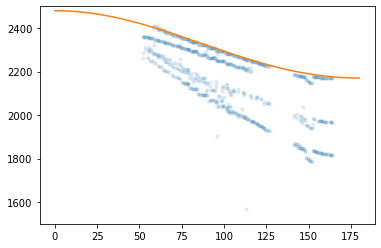

In [16]:

plt.plot(thetas[1],peakpos[1], '.', alpha=0.1)
#plt.plot(vinkler,2000*np.array(factors))
plt.plot(vinkler,Tb(2480,vinkler/360*2*np.pi))
plt.ylim(1500,energies[1])